In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import cv2
import os
import glob

In [4]:
# Initial parameters
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96, 96, 3)

data = []
labels = []

In [5]:
# Load image files from the dataset
image_files = [f for f in glob.glob(r'gender_dataset_face/**/*', recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [6]:
# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = 1 if label == "woman" else 0
    labels.append(label)

print(f"Loaded {len(data)} images with labels.")

Loaded 2307 images with labels.


In [7]:
# Preprocessing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

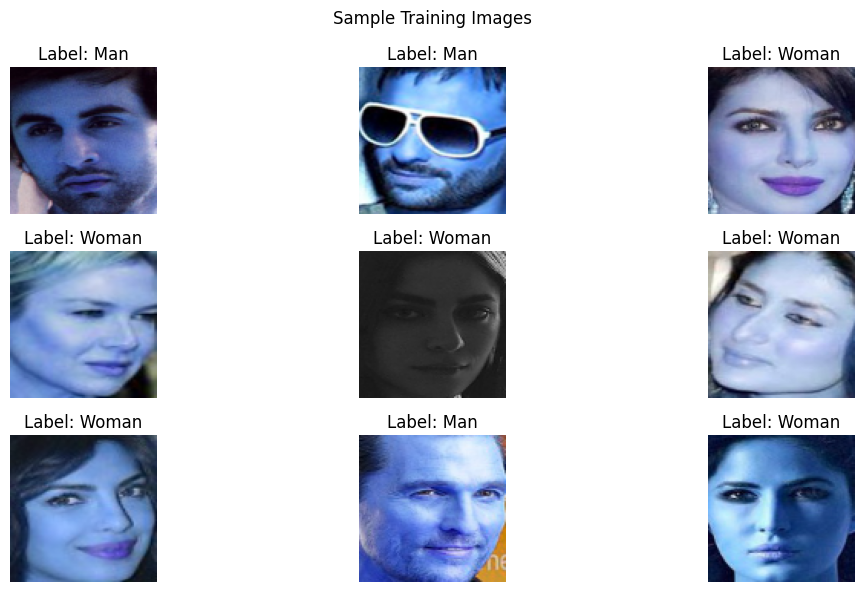

In [8]:
# Visualize sample images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(trainX) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(trainX[idx])
    plt.title(f"Label: {'Woman' if np.argmax(trainY[idx]) == 1 else 'Man'}")
    plt.axis('off')
plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.savefig('Images/sample_images.png')
plt.show()

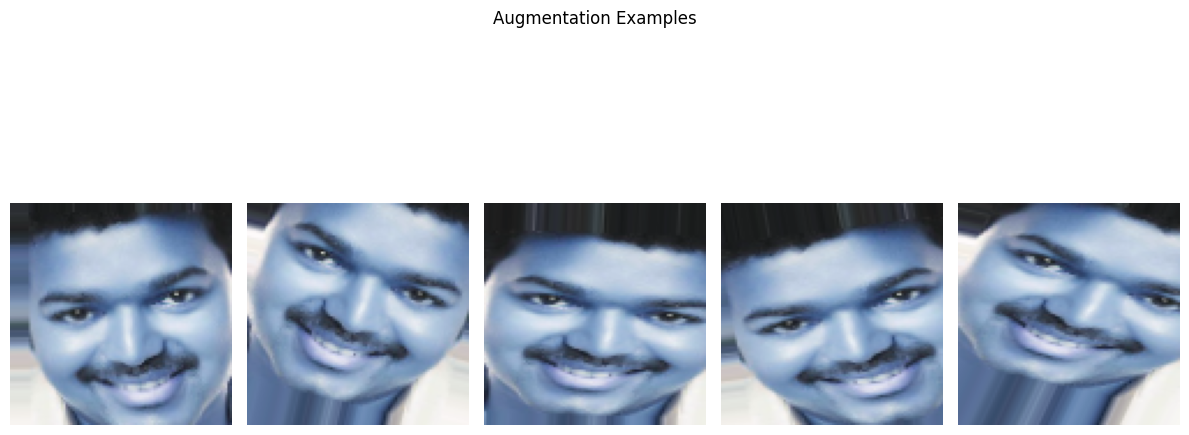

In [9]:
# Augmenting the dataset
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)

# Visualize data augmentation
sample_image = trainX[0]
aug_iter = aug.flow(np.expand_dims(sample_image, axis=0), batch_size=1)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    aug_image = next(aug_iter)[0]
    plt.imshow(aug_image)
    plt.axis('off')
plt.suptitle("Augmentation Examples")
plt.tight_layout()
plt.savefig('Images/augmented_examples.png')
plt.show()

In [ ]:
# Define the model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# Build and compile the model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

opt = Adam(learning_rate=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# Train the model
H = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // batch_size,
    epochs=epochs,
    verbose=1
)

# Save the model to disk in .h5 format
model.save('Model/gender_detection.h5')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


([<matplotlib.axis.YTick at 0x1f02bc80620>,
 [Text(0, 0, 'Man'), Text(0, 1, 'Woman')])

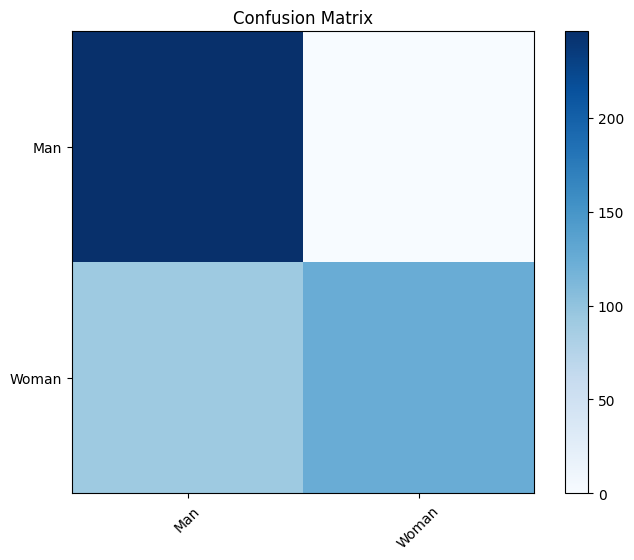

In [12]:
# Evaluate the model and plot confusion matrix
predY = model.predict(testX, batch_size=batch_size)
predY = np.argmax(predY, axis=1)
trueY = np.argmax(testY, axis=1)

# Generate confusion matrix
cm = confusion_matrix(trueY, predY)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = ['Man', 'Woman']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

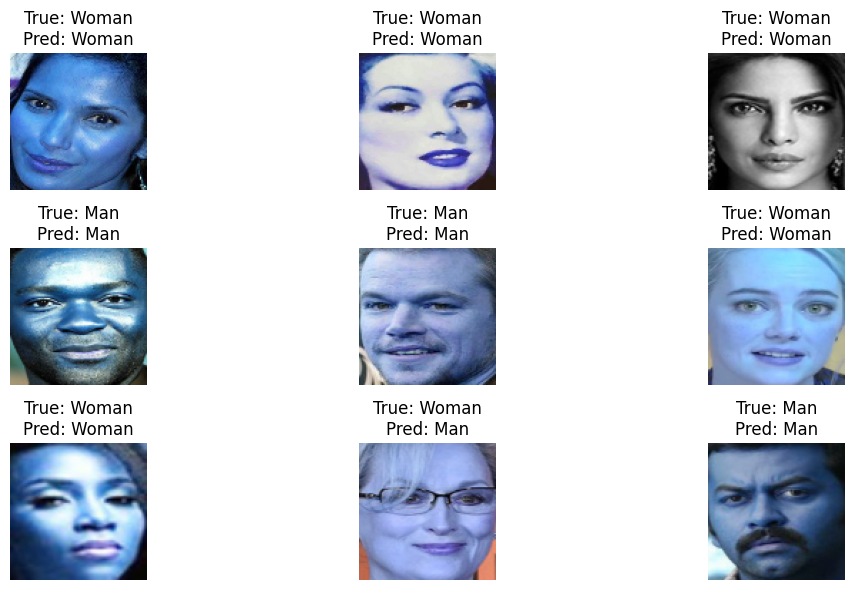

In [14]:
# Display predictions on test images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(testX) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(testX[idx])
    pred_label = 'Woman' if predY[idx] == 1 else 'Man'
    true_label = 'Woman' if trueY[idx] == 1 else 'Man'
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('Images/test_predictions.png')
plt.show()

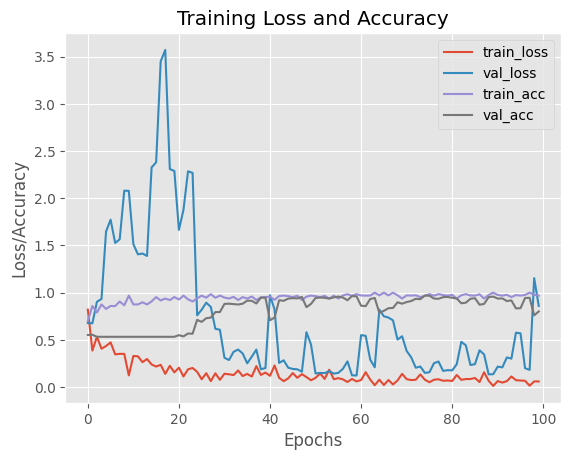

In [23]:
# Plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# Save the plot to disk
plt.savefig('Images/plot.png')